
# Atlas Processing - Initial Image Creation

- Documentation: https://nilearn.github.io/auto_examples/01_plotting/plot_surf_atlas.html
- Note: nilearn's 'surface.load_surface_data' function does not suppport .mgh / .mgz files; must use mri_convert or mris_convert (part of Freesurfer) to first convert to an acceptable format, e.g. .nii

In [1]:
import nilearn
from nilearn import surface
from nilearn import plotting

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import pickle
import collections

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from nilearn import datasets

destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
destrieux_dict = dict(enumerate([str(l)[2:-1] for l in destrieux_atlas.labels]))

## 0. Set up directories

In [3]:
# === DIRECTORIES === #

# input data directories
# overall format:
# -- hbn_dir/sub-{EID}/label_subdir/parc_filename

hbn_dir = '/oak/stanford/groups/jyeatman/HBN/BIDS_curated/derivatives/freesurfer'
label_subdir = '/label'
surf_subdir = '/surf'

curv_filename = 'lh.curv'
infl_filename = 'lh.inflated'
pial_filename = 'lh.pial'
parc_filename = 'lh.aparc.a2009s.annot'

# output data directories
out_data_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
image_out_subdir = 'parc-images'
image_out_dir = out_data_dir + '/' + image_out_subdir
image_out_dir
os.makedirs(image_out_dir, exist_ok=True)  # ensure image output directory exists
assert os.path.exists(image_out_dir)

# === LABELS === #

# important:
# select a subset of labels that are visible in  ventral view
# label = 43 was borderline and removed for convenience
labels_to_plot = [2, 19, 21, 23, 24, 25, 30, 37, 38, 50, 51, 57, 58, 59, 60, 61, 63, 65]

In [5]:
label_subdir = 'label/manual_label'
surf_subdir = 'surf'
data_dir = '/oak/stanford/groups/jyeatman/samjohns/samjohns-projects-backup/ots-data'
subjects = [s for s in os.listdir(data_dir) if 'long' in s] 
subjects.sort()

## Make images

In [7]:
sub_dfs = []

for sub in subjects:
    
    curv_file = os.path.join(data_dir, sub, surf_subdir, 'lh.curv')
    infl_file = os.path.join(data_dir, sub, surf_subdir, 'lh.inflated')
    label_dir = os.path.join(data_dir, sub, label_subdir)
    label_files = [f for f in os.listdir(label_dir) if ('.label' in f) and ('lh.' in f)]

    surf = surface.load_surf_mesh(infl_file)
    curv = surface.load_surf_data(curv_file)

    labels = []
    for l in label_files:
        labels.append(surface.load_surf_data(os.path.join(label_dir, l)))
    
    sub_df = pd.DataFrame({'Subject': sub, 'Filename': label_files, 'Label': labels, 'Mesh': [surf]*len(labels), 'Curv': [curv]*len(labels)})
    sub_dfs.append(sub_df)
    
df = pd.concat(sub_dfs)

In [8]:
all_label_files = list(df['Filename'].unique())
all_labels = sorted([l.split('.')[1] for l in all_label_files if 'lh.' in l])

l_inc = ['OTSa', 'OTSb', 'OTSc', 'OTSd', 'OTSe']
df['LabelName'] = df['Filename'].apply(lambda l: l.split('.')[1])
df_filtered = df[df['LabelName'].isin(l_inc)]
label_to_index = dict(zip(l_inc, list(range(2, len(l_inc) + 2))))

In [9]:
df_filtered['LabelIndex'] = df_filtered['LabelName'].apply(lambda name: label_to_index[name])
subjects_filtered = list(df_filtered['Subject'].unique())

/tmp/ipykernel_27867/2004794661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['LabelIndex'] = df_filtered['LabelName'].apply(lambda name: label_to_index[name])


In [10]:
df_filtered

,Subject,Filename,Label,Mesh,Curv,LabelName,LabelIndex
4,5006_T1.long.5006,lh.OTSb.label,"[40954, 40966, 40974, 41712, 41713, 41723, 417...","([[28.131681442260742, -119.46367645263672, -3...","[-0.30041084, -0.269485, -0.25894412, -0.29989...",OTSb,3
8,5006_T1.long.5006,lh.OTSa.label,"[6507, 6518, 6996, 6997, 6998, 7006, 7007, 701...","([[28.131681442260742, -119.46367645263672, -3...","[-0.30041084, -0.269485, -0.25894412, -0.29989...",OTSa,2
4,5010_T1.long.5010,lh.OTSb.label,"[16282, 16987, 16988, 16989, 16999, 17000, 170...","([[25.252391815185547, -132.74000549316406, -1...","[-0.4683316, -0.433789, -0.36071667, -0.276555...",OTSb,3
8,5010_T1.long.5010,lh.OTSa.label,"[5356, 5787, 6235, 6236, 6237, 6249, 6250, 625...","([[25.252391815185547, -132.74000549316406, -1...","[-0.4683316, -0.433789, -0.36071667, -0.276555...",OTSa,2
13,5010_T1.long.5010,lh.OTSc.label,"[32660, 32666, 32671, 32674, 32678, 32682, 332...","([[25.252391815185547, -132.74000549316406, -1...","[-0.4683316, -0.433789, -0.36071667, -0.276555...",OTSc,4
...,...,...,...,...,...,...,...
3,6120_T1.long.6120,lh.OTSb.label,"[21125, 21126, 21127, 21128, 21129, 21138, 211...","([[18.317821502685547, -130.4791717529297, -35...","[-0.33051383, -0.18729879, -0.39520746, -0.293...",OTSb,3
6,6120_T1.long.6120,lh.OTSa.label,"[8947, 8968, 9553, 9554, 9555, 9568, 9569, 957...","([[18.317821502685547, -130.4791717529297, -35...","[-0.33051383, -0.18729879, -0.39520746, -0.293...",OTSa,2
10,6120_T1.long.6120,lh.OTSc.label,"[47369, 47370, 47371, 47378, 47379, 47380, 473...","([[18.317821502685547, -130.4791717529297, -35...","[-0.33051383, -0.18729879, -0.39520746, -0.293...",OTSc,4
3,6121_T1.long.6121,lh.OTSb.label,"[31509, 31510, 31515, 31516, 31517, 31522, 315...","([[33.06694412231445, -120.617919921875, -3.54...","[-0.14980099, -0.09487074, -0.24212323, -0.296...",OTSb,3


In [11]:
df_filtered.sort_values('Subject')

,Subject,Filename,Label,Mesh,Curv,LabelName,LabelIndex
4,5006_T1.long.5006,lh.OTSb.label,"[40954, 40966, 40974, 41712, 41713, 41723, 417...","([[28.131681442260742, -119.46367645263672, -3...","[-0.30041084, -0.269485, -0.25894412, -0.29989...",OTSb,3
8,5006_T1.long.5006,lh.OTSa.label,"[6507, 6518, 6996, 6997, 6998, 7006, 7007, 701...","([[28.131681442260742, -119.46367645263672, -3...","[-0.30041084, -0.269485, -0.25894412, -0.29989...",OTSa,2
4,5010_T1.long.5010,lh.OTSb.label,"[16282, 16987, 16988, 16989, 16999, 17000, 170...","([[25.252391815185547, -132.74000549316406, -1...","[-0.4683316, -0.433789, -0.36071667, -0.276555...",OTSb,3
8,5010_T1.long.5010,lh.OTSa.label,"[5356, 5787, 6235, 6236, 6237, 6249, 6250, 625...","([[25.252391815185547, -132.74000549316406, -1...","[-0.4683316, -0.433789, -0.36071667, -0.276555...",OTSa,2
13,5010_T1.long.5010,lh.OTSc.label,"[32660, 32666, 32671, 32674, 32678, 32682, 332...","([[25.252391815185547, -132.74000549316406, -1...","[-0.4683316, -0.433789, -0.36071667, -0.276555...",OTSc,4
...,...,...,...,...,...,...,...
3,6120_T1.long.6120,lh.OTSb.label,"[21125, 21126, 21127, 21128, 21129, 21138, 211...","([[18.317821502685547, -130.4791717529297, -35...","[-0.33051383, -0.18729879, -0.39520746, -0.293...",OTSb,3
6,6120_T1.long.6120,lh.OTSa.label,"[8947, 8968, 9553, 9554, 9555, 9568, 9569, 957...","([[18.317821502685547, -130.4791717529297, -35...","[-0.33051383, -0.18729879, -0.39520746, -0.293...",OTSa,2
10,6120_T1.long.6120,lh.OTSc.label,"[47369, 47370, 47371, 47378, 47379, 47380, 473...","([[18.317821502685547, -130.4791717529297, -35...","[-0.33051383, -0.18729879, -0.39520746, -0.293...",OTSc,4
3,6121_T1.long.6121,lh.OTSb.label,"[31509, 31510, 31515, 31516, 31517, 31522, 315...","([[33.06694412231445, -120.617919921875, -3.54...","[-0.14980099, -0.09487074, -0.24212323, -0.296...",OTSb,3


In [9]:
def make_subject_stat_map(sub, df, return_mesh=True):

    sub_df = df[df['Subject'] == sub]

    sub_mesh = sub_df['Mesh'].iloc[0]
    sub_labs = list(sub_df['Label'])
    sub_inds = list(sub_df['LabelIndex']) 

    c = sub_mesh.coordinates.shape[0]
    m = np.ones(c)
    
    for l, i in zip(sub_labs, sub_inds):
        m[l] = float(i)
    
    if return_mesh:
        return m, sub_mesh
    else:
        return m

In [12]:
def make_single_image(mesh, stat_map, bg=None,
                      view=[210., 90.], output_file=None, 
                      fig=None, ax=None, title=None, cmap='tab20'):
    
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(8, 8))
    
    fig.suptitle(title)
    
    plotting.plot_surf_roi(mesh, stat_map
                           ,view=view
                           ,bg_map=bg
                           ,vmax=6.0
                           ,vmin=1.0
                           # ,bg_on_data=True
                           ,figure=fig
                           ,cmap=cmap
                           #,output_file=output_file   
                           #,threshold=20.01
                           #,colorbar=True
                          )

## General image-creation pipeline

In [13]:
from matplotlib import colors
cmap = colors.ListedColormap(['blue', 'green', 'yellow', 'red', 'purple'])
bounds = [1, 2, 3, 4, 5, 6]

In [12]:
out_base_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
out_parc_dir = out_base_dir + '/ots-parc-images-jitter'
out_curv_dir = out_base_dir + '/ots-curv-images-jitter'
os.makedirs(out_parc_dir, exist_ok=True)
os.makedirs(out_curv_dir, exist_ok=True)

In [13]:
def make_angles(njitter=20, scale=30, base_angle=None):
    noise = scale * (np.random.rand(njitter, 2) - 0.5)
    if base_angle is None:
        base_angle = np.array([210.0, 90.0])
    return noise + base_angle

def get_subject_labels(sub, df):
    curv = df[df['Subject'] == sub]['Curv'].iloc[0]
    stat, mesh = make_subject_stat_map(sub, df)
    return mesh, stat, curv

def make_ots_subject_images(sub, df, out_parc_path, out_curv_path, 
                            jitter=True, 
                            make_curv=True, 
                            cmap='tab20',
                            vmin=None, 
                            vmax=None):
        
    if jitter:
        angles = make_angles()
    else:
        angles = [[210.0, 90.0]]

    infl, stat, curv = get_subject_labels(sub, df)
    
    for a in angles:
        
        fig, ax = plt.subplots(figsize=(8, 8))
        plotting.plot_surf_roi(infl, stat
                               ,view=(a[0], a[1])
                               # ,bg_map=test_curv
                               # ,bg_on_data=True 
                               ,figure=fig
                               ,cmap=cmap
                               ,output_file=f'{out_parc_path}/{sub}-{a[0]:.2f}-{a[1]:.2f}-parc.png'
                               ,vmin=vmin
                               ,vmax=vmax
                               # ,threshold=25.0
                               # colorbar=True
                              )

        if make_curv:
            fig,  ax = plt.subplots(figsize=(8, 8))
            plotting.plot_surf_roi(infl, stat
                                   ,view=(a[0], a[1])
                                   ,bg_map=curv
                                   # ,bg_on_data=True 
                                   ,figure=fig
                                   ,cmap=None
                                   ,threshold=25.0
                                   ,output_file=f'{out_curv_path}/{sub}-{a[0]:.2f}-{a[1]:.2f}-curv.png'
                                   # colorbar=True
                                  )
        
    return

In [14]:
# main loop: don't execute this cell unless you want to go grab a coffee
run = False

if run:
    for sub in subjects_filtered:
        make_ots_subject_images(sub, df_filtered, 
                                out_parc_path=out_parc_dir, 
                                out_curv_path=out_curv_dir, 
                                cmap=cmap, 
                                vmin=1.0, 
                                vmax=6.0)
        
        print(f'{sub} completed ....')

In [24]:
# ots curv directories
curv_dir = '/scratch/groups/jyeatman/samjohns-projects/data/curv-images-jitter'
curv_mask_dir = '/scratch/groups/jyeatman/samjohns-projects/data/curv-mask-jitter'
os.makedirs(ots_curv_mask_dir , exist_ok=True)

# load previous angles
made_curvs = os.listdir(curv_dir)
made_curv_masks = os.listdir(curv_mask_dir)

In [30]:
in_dir = '/scratch/users/samjohns/samjohns-projects/data/parc-images-jitter'
out_dir = curv_mask_dir
made_curvs = os.listdir(in_dir)

In [31]:
made_subjects = []
made_angles = []

for m in made_curvs:
    
    msplit = m.split('-')
    angles = [float(a) for a in msplit[1:3]]
    subject = msplit[0]
    
    made_subjects.append(subject)
    made_angles.append(angles)

made_mask_subjects = []
made_mask_angles = []

for m in made_curv_masks:
    
    msplit = m.split('-')
    angles = [float(a) for a in msplit[1:3]]
    subject = msplit[0]
    
    made_mask_subjects.append(subject)
    made_mask_angles.append(angles)

ValueError: could not convert string to float: 'NDARNE511XHU'

In [34]:
made_curvs[0].split('-')

['sub', 'NDARNE511XHU', '221.65', '85.47', 'parc.png']

In [22]:
made_df = pd.DataFrame({'Subject': made_subjects, 'Angles': made_angles})
made_mask_df = pd.DataFrame({'Subject': made_mask_subjects, 'Angles': made_mask_angles})

In [23]:
len(made_mask_df)

800

In [42]:
row = made_mask_df.iloc[0]
sub = row[0]
a = row[1]

In [54]:
subangles = list(made_mask_df[made_mask_df.Subject == 'angela']['Angles'])

In [55]:
len(subangles)

0

In [51]:
a in subangles

True

In [63]:
remaining_subjects = list(set(made_df['Subject']) - set(made_mask_df['Subject']))
remaining_subjects

['6117_T1.long.6117', '6121_T1.long.6121', '6120_T1.long.6120']

In [64]:
for sub in remaining_subjects:
    # get subject data
    sub_df = df_filtered[df_filtered.Subject == sub]
    mesh = list(sub_df['Mesh'])[0]
    curv = list(sub_df['Curv'])[0]
    # make curvature mask
    curv_mask = np.zeros_like(curv)
    curv_mask[curv > 0] = 1.0
    
    # get subject angles
    subj_angles = list(made_df[made_df['Subject']==sub]['Angles'])
    
    # make images, one per view
    for a in subj_angles:
        fig, ax = plt.subplots(figsize=(8, 8))
        plotting.plot_surf_roi(mesh, curv_mask
            ,view=a
            # ,bg_on_data=True 
            ,figure=fig
            ,cmap='gray'
            ,threshold=0.0
            ,output_file=f'{ots_curv_mask_dir}/{sub}-{a[0]:.2f}-{a[1]:.2f}-curv-mask.png'
            # ,colorbar=True
            )

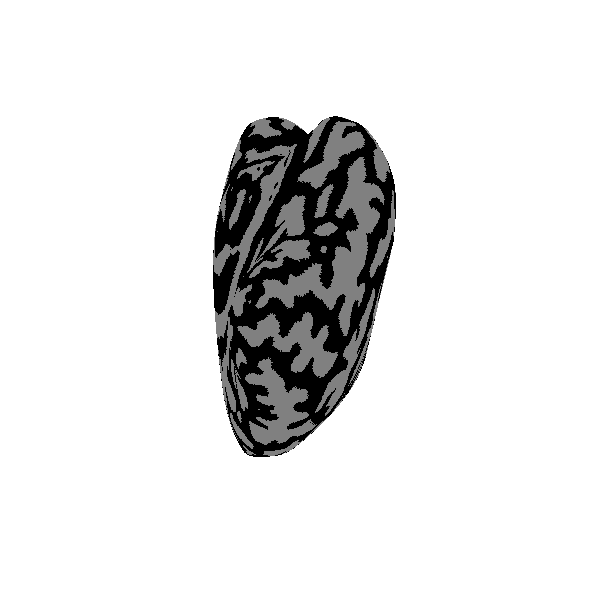

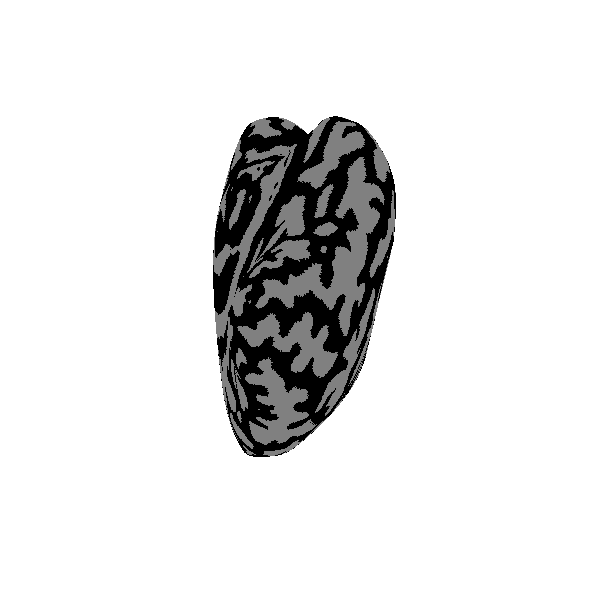

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
plotting.plot_surf_roi(mesh, curv_mask
    ,view=(210.0, 90.0)
    # ,bg_on_data=True 
    ,figure=fig
    ,cmap='gray'
    ,threshold=0.0
    # ,output_file=f'{out_curv_path}/{sub}-{a[0]:.2f}-{a[1]:.2f}-curv.png'
    # ,colorbar=True
    )

In [35]:
done_curv = os.listdir('/scratch/groups/jyeatman/samjohns-projects/data/parc-images-jitter-processed/curv-trans')

In [36]:
dc0 = done_curv[0]

In [37]:
def parse(st, j):
    dcs = st[:-4].split('-')
    for i in range(len(dcs)):
        if dcs[i] == '':
            dcs[i+1] = '-' + dcs[i+1]
    dcs = [d for d in dcs if d != '']
    return dcs[j]

def parse_name(st):
    return 'sub-' + parse(st, 1)

def parse_angle1(st):
    return float(parse(st, 2))

def parse_angle2(st):
    return float(parse(st, 3))

def parse_trans1(st):
    return int(parse(st, 6))

def parse_trans2(st):
    return int(parse(st, 7))

In [38]:
df_dc = pd.DataFrame({'Filename': done_curv})

In [39]:
df_dc['Subject'] = df_dc['Filename'].apply(parse_name)
df_dc['Angle1'] = df_dc['Filename'].apply(parse_angle1)
df_dc['Angle2'] = df_dc['Filename'].apply(parse_angle2)
df_dc['Shift1'] = df_dc['Filename'].apply(parse_trans1)
df_dc['Shift2'] = df_dc['Filename'].apply(parse_trans2)

In [40]:
df_dc

,Filename,Subject,Angle1,Angle2,Shift1,Shift2
0,sub-NDARFN790WHU-210.62-81.89-curv-trans--12--...,sub-NDARFN790WHU,210.62,81.89,-12,-20
1,sub-NDARDU602LPX-206.64-85.88-curv-trans--2--1...,sub-NDARDU602LPX,206.64,85.88,-2,-19
2,sub-NDARGB015CT3-208.56-82.77-curv-trans--22-1...,sub-NDARGB015CT3,208.56,82.77,-22,12
3,sub-NDARKM718VKX-201.47-92.39-curv-trans-0-0.npy,sub-NDARKM718VKX,201.47,92.39,0,0
4,sub-NDARWE818UA6-219.09-76.41-curv-trans--16-8...,sub-NDARWE818UA6,219.09,76.41,-16,8
...,...,...,...,...,...,...
439921,sub-NDARNJ687DMC-218.80-83.07-curv-trans-10-2.npy,sub-NDARNJ687DMC,218.80,83.07,10,2
439922,sub-NDARYH480GTD-215.23-76.91-curv-trans--17-2...,sub-NDARYH480GTD,215.23,76.91,-17,20
439923,sub-NDARXR566CDR-197.48-83.31-curv-trans--20-1...,sub-NDARXR566CDR,197.48,83.31,-20,19
439924,sub-NDARJA356XHT-216.09-85.63-curv-trans-8--20...,sub-NDARJA356XHT,216.09,85.63,8,-20


In [41]:
out_dir = '/scratch/groups/jyeatman/samjohns-projects/data/curv-mask-jitter'
os.makedirs(out_dir, exist_ok=True)

In [42]:
da = df_dc[['Subject', 'Angle1', 'Angle2']].drop_duplicates()
hbn_subs = list(da['Subject'].unique())

In [135]:
for sub in hbn_val_subjects[:5]:
    
    # get subject data
    infl = surface.load_surf_mesh(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{inf}')
    curv = surface.load_surf_data(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{cv}')
    
    # make curvature mask
    curv_mask = np.zeros_like(curv)
    curv_mask[curv > 0] = 1.0
        
    # make images
    fig, ax = plt.subplots(figsize=(8, 8))
    for statmap, mesh in [(curv, smwm), (curv_mask, infl)]:
        if mesh is smwm:
            name = 'white'
        else:
            name = 'inflated'
        plotting.plot_surf_roi(mesh, statmap
            ,view=[270., 90.]
            # ,bg_on_data=True 
            ,figure=fig
            ,cmap='gray'
            ,threshold=0.0
            ,output_file=f'{tutorial_dir}/{sub}-{}.png'
            # ,colorbar=True
            )

SyntaxError: f-string: empty expression not allowed (1514964100.py, line 27)

In [44]:
len(hbn_subs)

2361

In [45]:
for sub in hbn_subs:
    # get subject data
    # get subject data
    infl = surface.load_surf_mesh(f'{hbn_dir}/{sub}/surf/lh.inflated')
    curv = surface.load_surf_data(f'{hbn_dir}/{sub}/surf/lh.curv')
    
    # make curvature mask
    curv_mask = np.zeros_like(curv)
    curv_mask[curv > 0] = 1.0
    
    # get subject angles
    ds = da[da.Subject == sub]
    angles = [[a1, a2] for a1, a2 in zip(ds['Angle1'], ds['Angle2'])]
    
    # make images, one per view
    for a in subj_angles:
        fig, ax = plt.subplots(figsize=(8, 8))
        plotting.plot_surf_roi(infl, curv_mask
            ,view=a
            # ,bg_on_data=True 
            ,figure=fig
            ,cmap='gray'
            ,threshold=0.0
            ,output_file=f'{out_dir}/{sub}-{a[0]:.2f}-{a[1]:.2f}-curv-mask.png'
            # ,colorbar=True
            )

NameError: name 'subj_angles' is not defined

In [130]:
out_dir

'/scratch/groups/jyeatman/samjohns-projects/data/curv-mask-jitter'

## 1.(-1) Make Tutorial Images
- Binary curvature mask
- White and Inflated

In [115]:
data_dir = '/scratch/groups/jyeatman/samjohns-projects/data/'
tutorial_dir = os.path.join(data_dir, 'ots-tutorial')
os.makedirs(tutorial_dir, exist_ok=True)

In [116]:
jamie_dir = '/oak/stanford/groups/jyeatman/yarbus/AlexsProjects/WordsFieldOfView/WordsFOV_MRI_Derivatives/sub-585/anat'
jamie_surf_dir = '/oak/stanford/groups/jyeatman/yarbus/AlexsProjects/WordsFieldOfView/WordsFOV_MRI_Derivatives/sourcedata/freesurfer/sub-585/surf/'

In [117]:
# get validation subject EIDS
hbn_val_dir = os.listdir(data_dir + '/parc-images-jitter-processed/curv-trans-val')

In [118]:
hbn_val_subjects = []
hbn_val_angles = []

for m in hbn_val_dir:
    
    msplit = m.split('-')
    angles = [float(a) for a in msplit[2:4]]
    subject = msplit[1]
    
    hbn_val_subjects.append('sub-' + subject)
    hbn_val_angles.append(angles)

In [119]:
hbn_val_df = pd.DataFrame({'Subject': hbn_val_subjects, 'Angles': hbn_val_angles})

In [120]:
wm = 'lh.white'
inf = 'lh.inflated'
cv = 'lh.curv'

In [121]:
os.path.exists(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{wm}') and \
os.path.exists(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{inf}') and \
os.path.exists(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{cv}')

True

In [126]:
for sub in hbn_val_subjects[:5]:
    
    # get subject data
    infl = surface.load_surf_mesh(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{inf}')
    smwm = surface.load_surf_mesh(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{wm}')
    curv = surface.load_surf_data(f'{hbn_dir}/{hbn_val_subjects[0]}/surf/{cv}')
    
    # make curvature mask
    curv_mask = np.zeros_like(curv)
    curv_mask[curv > 0] = 1.0
        
    # make images
    fig, ax = plt.subplots(figsize=(8, 8))
    for statmap, mesh in [(curv, smwm), (curv_mask, infl)]:
        if mesh is smwm:
            name = 'white'
        else:
            name = 'inflated'
        plotting.plot_surf_roi(mesh, statmap
            ,view=[270., 90.]
            # ,bg_on_data=True 
            ,figure=fig
            ,cmap='gray'
            ,threshold=0.0
            ,output_file=f'{tutorial_dir}/{sub}-{}.png'
            # ,colorbar=True
            )

ValueError: The input type is not recognized. '/oak/stanford/groups/jyeatman/HBN/BIDS_curated/derivatives/freesurfer/sub-NDARDU602LPX/surf/lh.smoothwm' was given while valid inputs are one of the following file formats: .gii, .gii.gz, Freesurfer specific files such as .orig, .pial, .sphere, .white, .inflated or two Numpy arrays organized in a list, tuple or a namedtuple with the fields "coordinates" and "faces"

In [131]:
# get subject data
infl = surface.load_surf_mesh(f'{jamie_surf_dir}{inf}')
smwm = surface.load_surf_mesh(f'{jamie_surf_dir}{wm}')
curv = surface.load_surf_data(f'{jamie_surf_dir}{cv}')

# make curvature mask
curv_mask = np.zeros_like(curv)
curv_mask[curv > 0] = 1.0

# make images
fig, ax = plt.subplots(figsize=(8, 8))
for statmap, mesh in [(curv, smwm), (curv_mask, infl)]:
    if mesh is smwm:
        name = 'white'
    else:
        name = 'inflated'
    plotting.plot_surf_roi(mesh, statmap
        ,view=[270., 90.]
        # ,bg_on_data=True 
        ,figure=fig
        ,cmap='gray'
        ,threshold=0.0
        ,output_file=f'{tutorial_dir}/JME-{name}.png'
        # ,colorbar=True
        )

## 2. Create pixel2vertex maps

In [35]:
sub = subjects[0]
curv_path = f'{hbn_dir}/{sub}{surf_subdir}/{curv_filename}'
infl_path = f'{hbn_dir}/{sub}{surf_subdir}/{infl_filename}'

In [36]:
curv = surface.load_surf_data(curv_path)
infl = surface.load_surf_mesh(infl_path)

ValueError: No files matching path: /scratch/users/samjohns/HBN/BIDS_curated/derivatives/freesurfer/5006_T1.long.5006surf/lh.curv

In [ ]:
coords = infl.coordinates

xs = coords[:, 0]
ys = coords[:, 1]
zs = coords[:, 2]

In [5]:
def make_subject_images(subdir, savedir, save_prefix, a=[210., 0.]):
    """ Make subject image to record x, y, and z of vertices.
        Saved as 3 grayscale images.
    """
    xrange = 60.
    yrange = 150.
    zrange = 100.
    ranges = [xrange, yrange, zrange]
    
    curv_path = f'{subdir}/surf/lh.curv'
    infl_path = f'{subdir}/surf/lh.inflated'
    curv = surface.load_surf_data(curv_path)
    infl = surface.load_surf_mesh(infl_path)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(3):
        
        plotting.plot_surf_roi(infl, infl.coordinates[:, i]
                               ,view=(a[0], a[1])
                               # ,bg_map=test_curv
                               # ,bg_on_data=True 
                               ,figure=fig
                               ,cmap='gray'
                               ,output_file=f'{savedir}/{save_prefix}-{a[0]:.2f}-{a[1]:.2f}-coord-{i}.png'
                               ,vmin=-ranges[i]
                               ,vmax=ranges[i]
                               # ,threshold=25.0
                               # colorbar=True
                              )

In [6]:
xrange = 60.
yrange = 150.
zrange = 100.
ranges = [xrange, yrange, zrange]

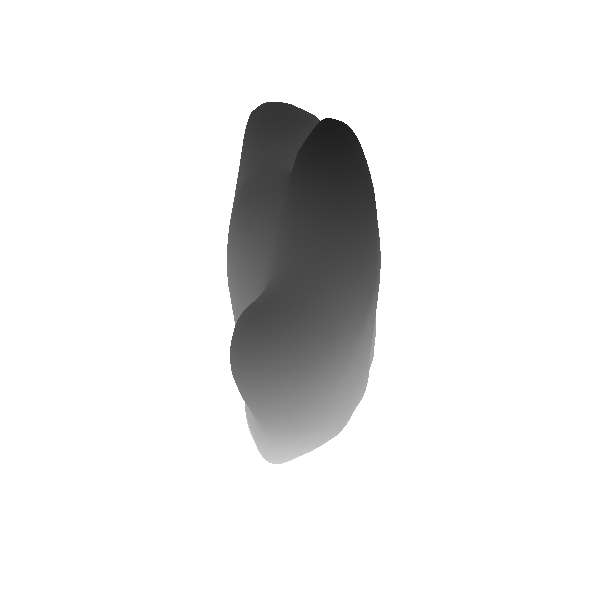

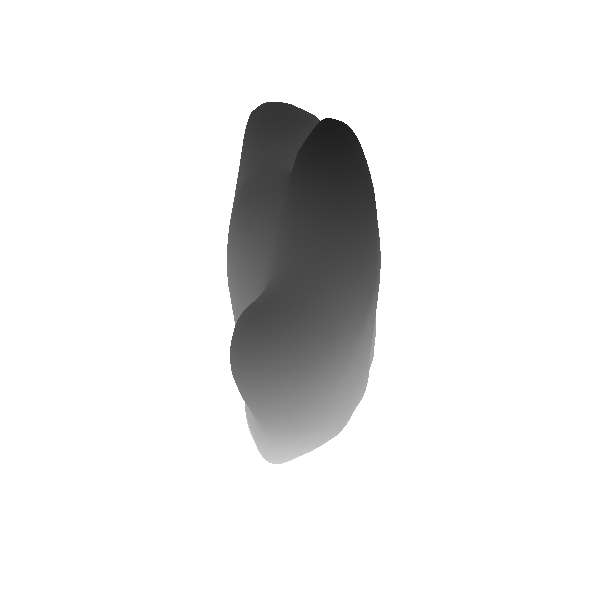

In [12]:
i = 2
a = np.array([0., 0.])
fig, ax = plt.subplots(figsize=(8, 8))

plotting.plot_surf_roi(infl, coords[:, i]
                       ,view=(210., 90.)
                       # ,bg_map=test_curv
                       # ,bg_on_data=True 
                       ,figure=fig
                       ,cmap='gray'
                       #,output_file=f'{out_path}/{sub}-{a[0]:.2f}-{a[1]:.2f}-coord-{i}.png'
                       ,vmin=-ranges[i]
                       ,vmax=ranges[i]
                       # ,threshold=25.0
                       # colorbar=True
                      )

In [13]:
imgs = [f for f in os.listdir() if 'coord' in f]

In [14]:
imgs.sort()

In [15]:
imgs

['sub-NDARAA075AMK-0.00-0.00-coord-0.png',
 'sub-NDARAA075AMK-0.00-0.00-coord-1.png',
 'sub-NDARAA075AMK-0.00-0.00-coord-2.png']

In [15]:
img_x = Image.open(imgs[0])
img_y = Image.open(imgs[1])
img_z = Image.open(imgs[2])

In [16]:
np_x = np.array(img_x)[:, :, 0]  # note: all three color channels are equal; alpha channel irrelevant
np_y = np.array(img_y)[:, :, 0]
np_z = np.array(img_z)[:, :, 0]

In [10]:
def get_coords(arr, vrange, img_max=255.0):
    """ Convert color value (default: 0 - 255) into coordinate value.
    """
    img_max = float(img_max)  # in case img_max is supplied as int
    arr = arr.astype(dtype=np.float32)
    arr[arr==img_max] = np.nan  # set max (white background to nan)
    arr *= (2 * vrange / img_max)
    arr -= vrange
    return arr

def get_pixel_coords(np_x, np_y, np_z, xrange, yrange, zrange, img_max=255.0):
    """ Convert color into coordinate, once for each coordinate (x, y, z)
    """
    xc = get_coords(np_x, xrange)
    yc = get_coords(np_y, yrange)
    zc = get_coords(np_z, zrange)
    return np.stack([xc, yc, zc], axis=2)

def closest_coord(pixel_coords, vertex_coord, return_distance=False):
    """ Find the pixel whose (x, y, z) location is closest to that of a given vertex.
    """
    diffs = np.square(pixel_coords - vertex_coord)
    diffs = diffs.sum(axis=2)
    am = np.nanargmin(diffs)  # find the index `am` of minimum distance pixel
    dy = diffs.shape[1]
    indx = am // dy
    indy = am % dy
    if return_distance:
        return indx, indy, np.sqrt(diffs[indx, indy])  # convert `am` into 2D pixel location
    else:
        return indx, indy

def coords_to_vertices(pixel_coords, vertex_coords, return_distances=False):
    """ Loops over all vertices to match them to their closest pixels.
    """
    shape = pixel_coords.shape[:2]
    vertex_dir = {}
    distance_dir = {}
    for i in range(shape[0]):
        for j in range(shape[1]):
            vertex_dir[(i, j)] = []
    
    for v, vc in enumerate(vertex_coords):
        if return_distances:
            xi, yi, d = closest_coord(pixel_coords, vc, return_distance=True)
        else:
            xi, yi = closest_coord(pixel_coords, vc, return_distance=False)
        append_val = v
        if return_distances:
            append_val = [v, d]
        vertex_dir[(xi, yi)].append(append_val)
        if v % 1000 == 0:
            print(f'Assigned {v} vertices...')
    
    return vertex_dir

def px_2_coord(vcoords, pcoords, px_vertex_dict, distance_dict=False):
    coords_vert_recon = np.zeros_like(vcoords)
    for k, v in px_vertex_dict.items():
        i, j = k  # unpack k
        coord = pcoords[i, j, :]
        for vertex in v:
            if distance_dict:
                vertex = vertex[0]
            coords_vert_recon[vertex] = coord
    return coords_vert_recon

In [18]:
pcs = get_pixel_coords(np_x, np_y, np_z, xrange, yrange, zrange)

In [22]:
pcs.shape, coords.shape

((576, 576, 3), (131784, 3))

In [23]:
vertex_2_px_dict = coords_to_vertices(pcs, coords, return_distances=True)

Assigned 0 vertices...
Assigned 1000 vertices...
Assigned 2000 vertices...
Assigned 3000 vertices...
Assigned 4000 vertices...
Assigned 5000 vertices...
Assigned 6000 vertices...
Assigned 7000 vertices...
Assigned 8000 vertices...
Assigned 9000 vertices...
Assigned 10000 vertices...
Assigned 11000 vertices...
Assigned 12000 vertices...
Assigned 13000 vertices...
Assigned 14000 vertices...
Assigned 15000 vertices...
Assigned 16000 vertices...
Assigned 17000 vertices...
Assigned 18000 vertices...
Assigned 19000 vertices...
Assigned 20000 vertices...
Assigned 21000 vertices...
Assigned 22000 vertices...
Assigned 23000 vertices...
Assigned 24000 vertices...
Assigned 25000 vertices...
Assigned 26000 vertices...
Assigned 27000 vertices...
Assigned 28000 vertices...
Assigned 29000 vertices...
Assigned 30000 vertices...
Assigned 31000 vertices...
Assigned 32000 vertices...
Assigned 33000 vertices...
Assigned 34000 vertices...
Assigned 35000 vertices...
Assigned 36000 vertices...
Assigned 37000

In [24]:
len(vertex_2_px_dict.keys())

331776

In [25]:
576**2

331776

In [137]:
save = False
if save:
    with open('vertex_2_px_dict.pkl', 'wb') as f:
        pickle.dump(vertex_2_px_dict, f)

In [138]:
len(vertex_2_px_dict.keys())

331776

In [45]:
pcs.shape, coords.shape

((576, 576, 3), (131784, 3))

In [46]:
vcoords_recon = px_2_coord(coords, pcs, vertex_2_px_dict, distance_dict=True)

In [49]:
squared_euclidean_errors = np.square(vcoords_recon - coords).sum(axis=1)
average_distance_error = np.mean(np.sqrt(squared_euclidean_errors))
average_distance_error

18.678983142198913

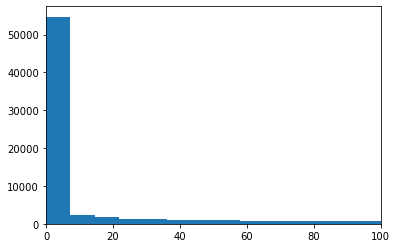

In [56]:
plt.hist(squared_euclidean_errors, bins=1000)
plt.xlim(0, 100)
plt.show()

In [67]:
len(squared_euclidean_errors[squared_euclidean_errors < 10.0])

55808

In [68]:
surf_map_recon = np.zeros_like(coords[:, 0])
mask = squared_euclidean_errors < 10.0
surf_map_recon[mask] = 1.0

In [5]:
plotting.plot_surf(infl, surf_map_recon, view=(30., 90.))

## Include downsampling

In [74]:
ns = 256

img_x = Image.open(imgs[0])
img_y = Image.open(imgs[1])
img_z = Image.open(imgs[2])

img_xdown = img_x.resize((ns, ns))
img_ydown = img_y.resize((ns, ns))
img_zdown = img_z.resize((ns, ns))

np_xdown = np.array(img_xdown)[:, :, 0]  # note: all three color channels are equal; alpha channel irrelevant
np_ydown = np.array(img_ydown)[:, :, 0]
np_zdown = np.array(img_zdown)[:, :, 0]

In [156]:
pcs_down = get_pixel_coords(np_xdown, np_ydown, np_zdown, xrange, yrange, zrange)
vertex_2_pxdown_dict = coords_to_vertices(pcs_down, coords)

Assigned 0 vertices...
Assigned 1000 vertices...
Assigned 2000 vertices...
Assigned 3000 vertices...
Assigned 4000 vertices...
Assigned 5000 vertices...
Assigned 6000 vertices...
Assigned 7000 vertices...
Assigned 8000 vertices...
Assigned 9000 vertices...
Assigned 10000 vertices...
Assigned 11000 vertices...
Assigned 12000 vertices...
Assigned 13000 vertices...
Assigned 14000 vertices...
Assigned 15000 vertices...
Assigned 16000 vertices...
Assigned 17000 vertices...
Assigned 18000 vertices...
Assigned 19000 vertices...
Assigned 20000 vertices...
Assigned 21000 vertices...
Assigned 22000 vertices...
Assigned 23000 vertices...
Assigned 24000 vertices...
Assigned 25000 vertices...
Assigned 26000 vertices...
Assigned 27000 vertices...
Assigned 28000 vertices...
Assigned 29000 vertices...
Assigned 30000 vertices...
Assigned 31000 vertices...
Assigned 32000 vertices...
Assigned 33000 vertices...
Assigned 34000 vertices...
Assigned 35000 vertices...
Assigned 36000 vertices...
Assigned 37000

In [164]:
coords_recon = px_2_coord(vcoords=coords, pcoords=pcs_down, px_vertex_dict=vertex_2_pxdown_dict)

In [176]:
squared_euclidean_error = np.square(coords_recon - coords).sum(axis=1)
average_distance_error = np.mean(np.sqrt(squared_euclidean_error))
average_distance_error

8.357668123519224

In [177]:
print(f'xrange: {(-xrange, xrange)}')
print(f'yrange: {(-yrange, yrange)}')
print(f'zrange: {(-zrange, zrange)}')

xrange: (-60.0, 60.0)
yrange: (-150.0, 150.0)
zrange: (-100.0, 100.0)


## Test on (already-made) parc-jitter images

In [11]:
parc_dir = '../data/parc-images-jitter-processed/parc'
subs_pj = os.listdir(parc_dir)

In [12]:
npy0_fn = subs_pj[0]
npy0_fn

'sub-NDARMX277VHC-206.24-84.84-parc.npy'

In [13]:
eid0 = npy0_fn[:16] 

In [49]:
def angles_from_fname(fname, split_str='parc'):
    astr0 = fname.split(split_str)[0][17:-1]
    astr01 = astr0.split('-')
    m1 = -1 if astr01[0] == '' else 1
    m2 = -1 if astr01[-2] == '' else 1
    astr02 = [float(s) for s in astr01 if s != '']
    astr02[0] *= m1
    astr02[1] *= m2
    return astr02

In [50]:
a0 = angles_from_fname(npy0_fn)
a0

[206.24, 84.84]

In [16]:
npy0 = np.load(f'{parc_dir}/{npy0_fn}')
npy0.shape

(256, 256)

In [17]:
subdir0 = f'{hbn_dir}/{eid0}'
os.listdir(subdir0)

['surf', 'label', 'touch', 'stats', 'tmp', 'scripts', 'trash', 'mri']

In [18]:
savedir='.'

In [19]:
make_subject_images(subdir0, savedir=savedir, save_prefix=eid0, a=a0)

In [24]:
out_path='.'

In [26]:
coord_imgs_fns0 = [s for s in os.listdir(out_path) if eid0 in s] 

In [29]:
coord_imgs_fns0 = sorted(coord_imgs_fns0)

In [30]:
img02 = Image.open(coord_imgs_fns0[2])

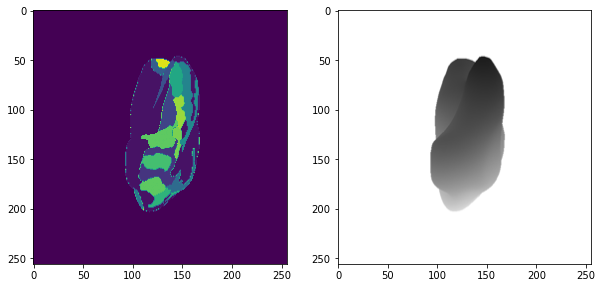

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(npy0)
ax[1].imshow(img02.resize((256, 256)))

In [33]:
ns = 256

imgs = coord_imgs_fns0

img_x = Image.open(imgs[0])
img_y = Image.open(imgs[1])
img_z = Image.open(imgs[2])

img_xdown = img_x.resize((ns, ns))
img_ydown = img_y.resize((ns, ns))
img_zdown = img_z.resize((ns, ns))

np_xdown = np.array(img_xdown)[:, :, 0]  # note: all three color channels are equal; alpha channel irrelevant
np_ydown = np.array(img_ydown)[:, :, 0]
np_zdown = np.array(img_zdown)[:, :, 0]

In [36]:
np_xdown.min(), np_xdown.max()

(17, 255)

In [39]:
sub0_infl = f'{hbn_dir}/{eid0}/surf/lh.inflated'
sub0_curv = f'{hbn_dir}/{eid0}/surf/lh.curv'
sub0_parc = f'{hbn_dir}/{eid0}/label/{parc_filename}'

infl0 = surface.load_surf_mesh(sub0_infl)
curv0 = surface.load_surf_data(sub0_curv)
parc0 = surface.load_surf_data(sub0_parc)
coords0 = infl0.coordinates

In [40]:
coords0.shape

(130418, 3)

In [41]:
pcs_down = get_pixel_coords(np_xdown, np_ydown, np_zdown, xrange, yrange, zrange)
vertex_2_pxdown_dict = coords_to_vertices(pcs_down, coords0)

Assigned 0 vertices...
Assigned 1000 vertices...
Assigned 2000 vertices...
Assigned 3000 vertices...
Assigned 4000 vertices...
Assigned 5000 vertices...
Assigned 6000 vertices...
Assigned 7000 vertices...
Assigned 8000 vertices...
Assigned 9000 vertices...
Assigned 10000 vertices...
Assigned 11000 vertices...
Assigned 12000 vertices...
Assigned 13000 vertices...
Assigned 14000 vertices...
Assigned 15000 vertices...
Assigned 16000 vertices...
Assigned 17000 vertices...
Assigned 18000 vertices...
Assigned 19000 vertices...
Assigned 20000 vertices...
Assigned 21000 vertices...
Assigned 22000 vertices...
Assigned 23000 vertices...
Assigned 24000 vertices...
Assigned 25000 vertices...
Assigned 26000 vertices...
Assigned 27000 vertices...
Assigned 28000 vertices...
Assigned 29000 vertices...
Assigned 30000 vertices...
Assigned 31000 vertices...
Assigned 32000 vertices...
Assigned 33000 vertices...
Assigned 34000 vertices...
Assigned 35000 vertices...
Assigned 36000 vertices...
Assigned 37000

In [42]:
len(vertex_2_pxdown_dict), sum([len(v) for k, v in vertex_2_pxdown_dict.items()])

(65536, 130418)

In [43]:
pcs_down.shape

(256, 256, 3)

In [44]:
sum([len(l) for l in vertex_2_pxdown_dict.values()])

130418

In [46]:
os.listdir(f'{hbn_dir}/{eid0}')

['surf', 'label', 'touch', 'stats', 'tmp', 'scripts', 'trash', 'mri']

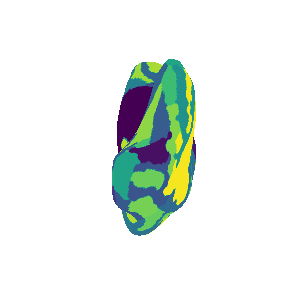

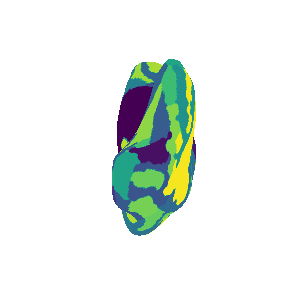

In [51]:
plotting.plot_surf(infl0, parc0, view=a0, cmap='viridis')

In [52]:
coords0.shape, curv0.shape

((130418, 3), (130418,))

In [53]:
pcs_down.shape

(256, 256, 3)

In [54]:
coords_recon = px_2_coord(vcoords=coords0, pcoords=pcs_down, px_vertex_dict=vertex_2_pxdown_dict)

In [55]:
coords_recon.shape

(130418, 3)

In [56]:
squared_euclidean_errors = np.square(coords_recon - coords0).sum(axis=1)
average_distance_error = np.mean(np.sqrt(squared_euclidean_errors))
average_distance_error

7.913802156442358

In [66]:
mask = squared_euclidean_errors > 10.0

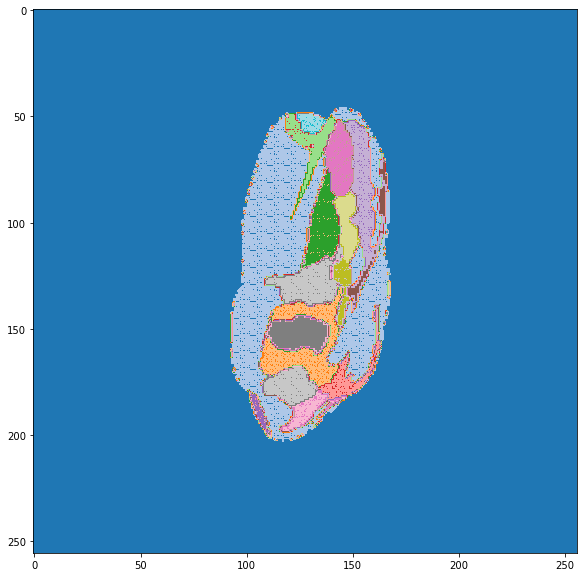

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(npy0, cmap='tab20')

In [59]:
npy0[150, 120], npy0[0,0]  # cort bg value, image bg value

(14.0, 0.0)

In [67]:
label_map = np.zeros_like(coords0[:, 0])
for k, v in vertex_2_pxdown_dict.items():
    i, j = k
    for vertex in v:
        label_map[vertex] = npy0[i, j]
label_map.shape

(130418,)

In [68]:
label_map[mask] = 1.0

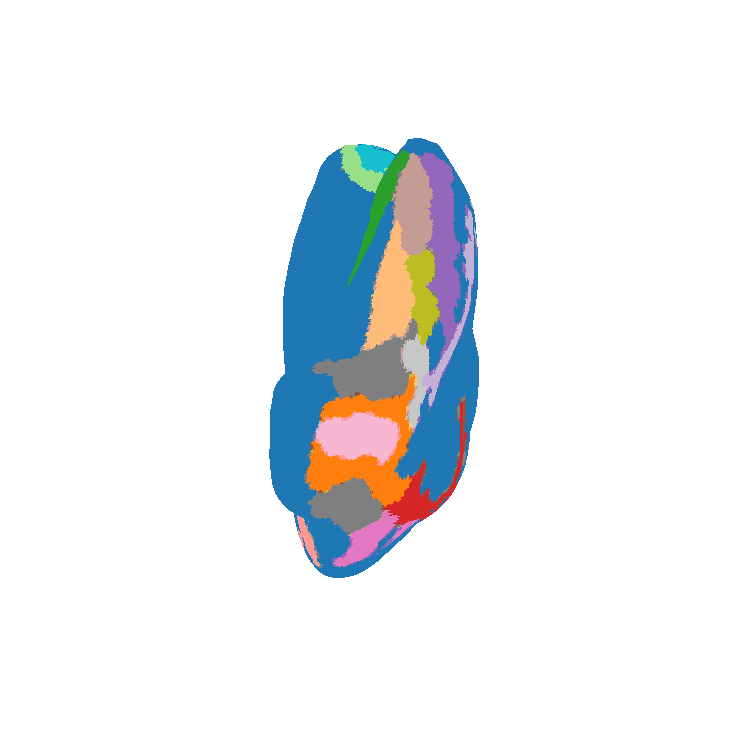

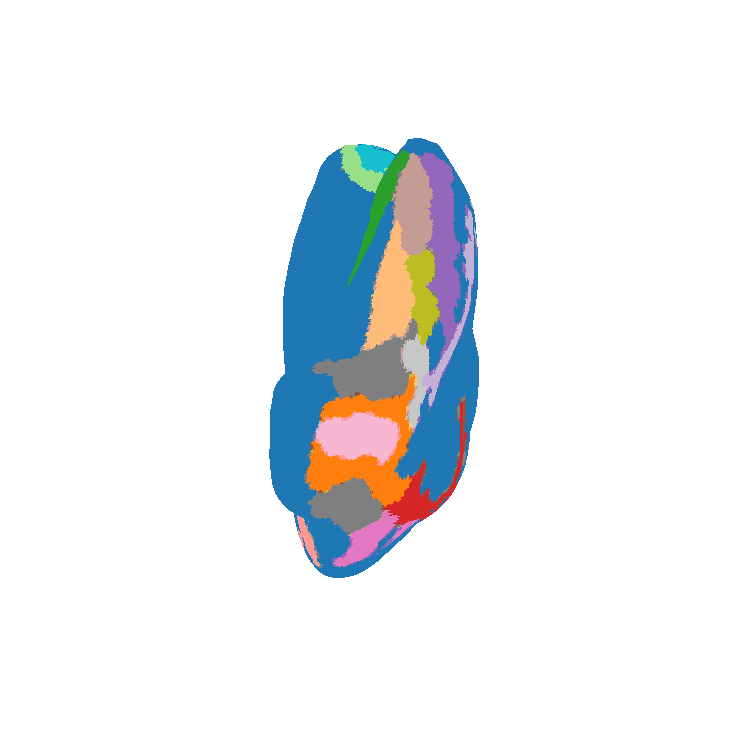

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
a = a0
plotting.plot_surf_roi(infl0, label_map
                       ,view=(a[0], a[1])
                       # ,bg_map=test_curv
                       # ,bg_on_data=True 
                       ,figure=fig
                       ,cmap='tab20'
                       # ,output_file=f'{out_parc_path}/{sub}-{a[0]:.2f}-{a[1]:.2f}-parc.png'   
                       # ,threshold=25.0
                       # colorbar=True
                      )

In [187]:
coords_recon[mask] = 1.0

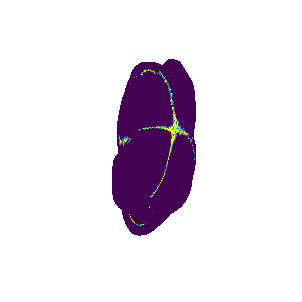

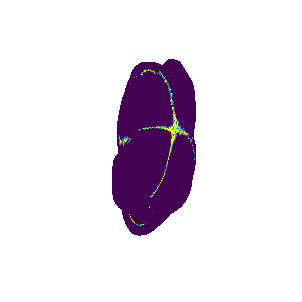

In [190]:
plotting.plot_surf(infl0, mask, view=a)

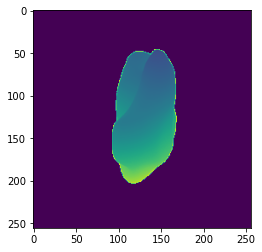

In [217]:
plt.imshow(np.nan_to_num(pcs_down[:,:, 1], nan=-200.0))

In [215]:
np.nanmax(pcs_down[:,:, 2])

99.21568

In [ ]:
plt.hist(square)